In here we use this framework to analyze the AFW smoother, a 4-color overlap smoother, for the 2d curl curl equation as described and analyzed in https://epubs.siam.org/doi/abs/10.1137/070679119.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import alfa

In [2]:
# define underlying curl curl operator
L = alfa.gallery.operators.curlcurl(.01)
I = alfa.tools.identity(L.C)  # identity
# restriction operator for the coarse grid correction
R = alfa.gallery.operators.curlcurl_restriction()
P = R.transpose()  # prolongation
Lc = R@L@P  # coarse grid operator

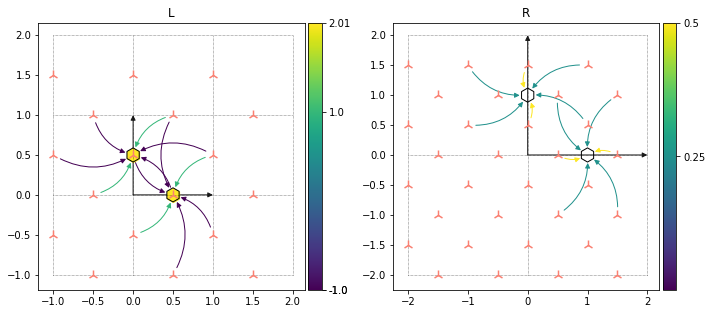

In [3]:
# plot L and R:
plt.figure()
plt.gcf().set_figwidth(15)
plt.subplot(121)
L.plot()
plt.title("L")
plt.subplot(122)
R.plot()
plt.title("R")
plt.gcf().set_figheight(10)
plt.gcf().set_figwidth(10)
plt.tight_layout()

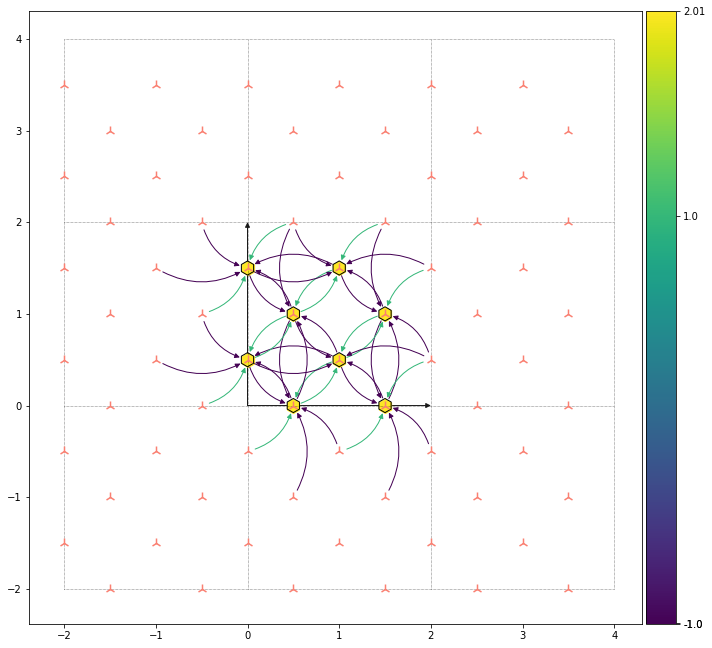

In [4]:
slattice = alfa.Lattice([[2, 0], [0, 2]])
Ls = L.wrt_lattice(slattice)
Ls.normalize()

plt.figure()
Ls.plot()
plt.gcf().set_figheight(10)
plt.gcf().set_figwidth(10)
plt.tight_layout()

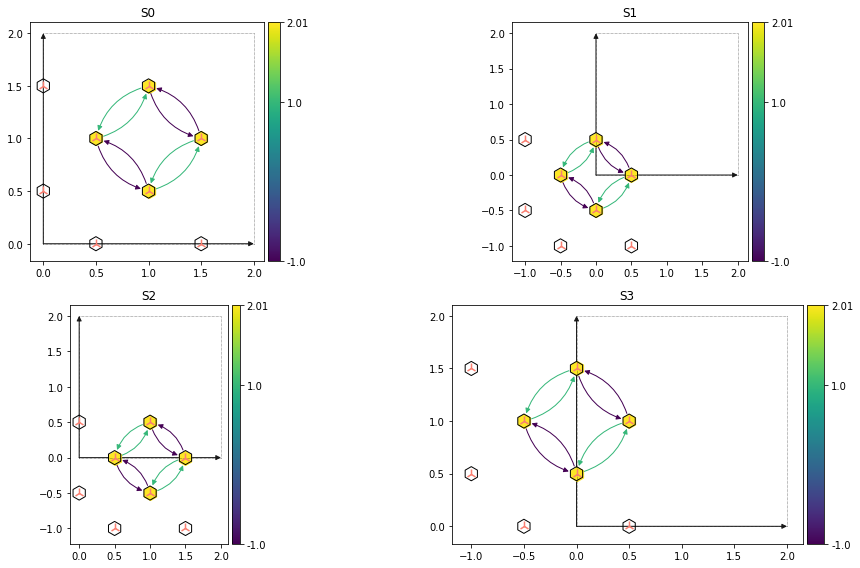

In [5]:
# 2. Extract multipliers
shifts = [np.asarray([0, 0]), np.asarray([-1, -1]), np.asarray([0, -1]),
          np.asarray([-1, 0]), ]
idx = [3, 4, 5, 7]

S = {}
for j in range(len(shifts)):
    Ls_shifted = Ls.change_structure_elements(
        [x + L.C.A@shifts[j] for x in Ls.C.s])
    stmp = alfa.tools.central_multiplier_of(Ls_shifted, idx)
    S = {**S, **{'S' + str(j): stmp}}
# plot
# before normalization
plt.figure(figsize=(15, 8))
for j, key in enumerate(S):
    plt.subplot(2, 2, j+1)
    S[key].plot()
    plt.title(key)

plt.tight_layout()

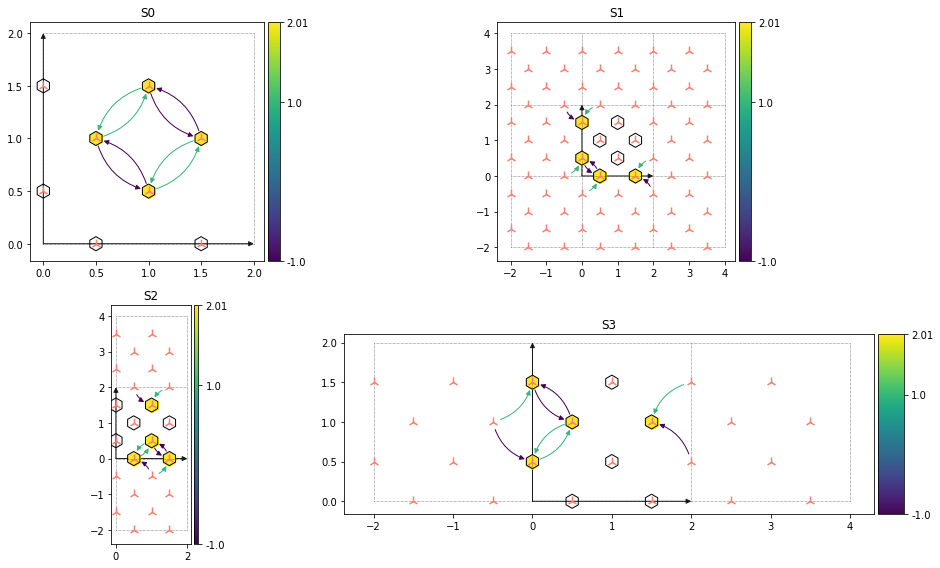

In [6]:
# plot after normalization.
plt.figure(figsize=(15, 8))
for j, key in enumerate(S):
    plt.subplot(2, 2, j+1)
    S[key].normalize()
    S[key].plot()
    plt.title(key)

plt.tight_layout()

In [7]:
# Construct the error propagator of the smoother (\product (I-S_i^\dagger L) ) and the two-grid correction as a string.
# This string is evaluated on the level of symbols.
#

# indices 0,1, .. 5
X = {**{x: eval(x) for x in ['I', 'L', 'P', 'Lc', 'R']}, **S}

# Construct smoother string.
Gstr = ''
for i in [0, 1, 2, 3]:
    pinv_si_str = "pinv('S" + str(i) + "')"
    Gstr += "@('I' - " + pinv_si_str + "@'L')"
Gstr = Gstr[1:]

# construct coarse grid correction string
Kstr = "@('I' - 'P'@pinv('Lc')@'R'@'L')@"

print("Smoother Gstr : " + Gstr)
print("Coarsegridcorrection Kstr : " + Kstr)

Smoother Gstr : ('I' - pinv('S0')@'L')@('I' - pinv('S1')@'L')@('I' - pinv('S2')@'L')@('I' - pinv('S3')@'L')
Coarsegridcorrection Kstr : @('I' - 'P'@pinv('Lc')@'R'@'L')@


### Reproducing plot in Figure 6.3, right, of https://epubs.siam.org/doi/abs/10.1137/070679119.

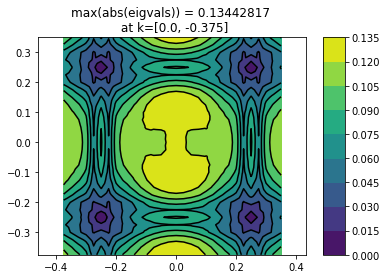

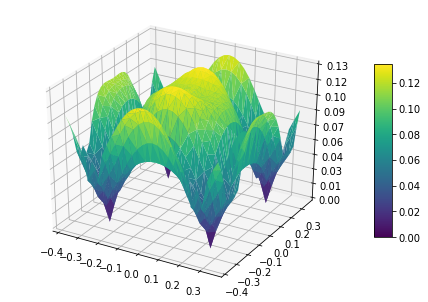

In [8]:
# Smoothing analysis of the smoother.
smoother = alfa.Operator_Composition(X, Gstr)
smoother.discretize_frequency_space(30, [-3/4, 3/4])
smoother.compute_spectrum(None, L.C, 1)  # We filter out the small frequencies

# plot...
plt.figure()
smoother.plot_spectrum()
plt.figure()
smoother.plot_spectrum_3d()

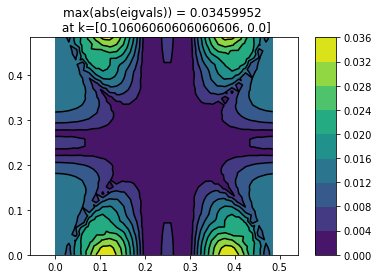

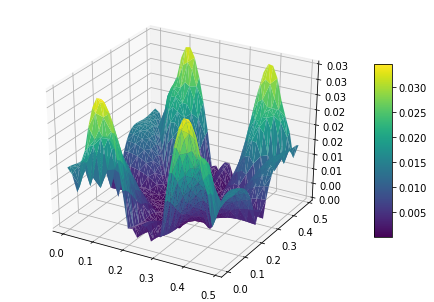

In [9]:
# analysis of the two-grid method.
twogrid = alfa.Operator_Composition(X, Gstr + Kstr + Gstr)
twogrid.compute_spectrum(33)  # resolution of the dual lattice: 33x33

# plot...
plt.figure()
twogrid.plot_spectrum()
plt.figure()
twogrid.plot_spectrum_3d()

# Discrepancies to the paper from Boonen, Lent and Vandewalle

We obtain exactly the same convergence rates as in the paper when we reverse the ordering in the post-smoothing step:

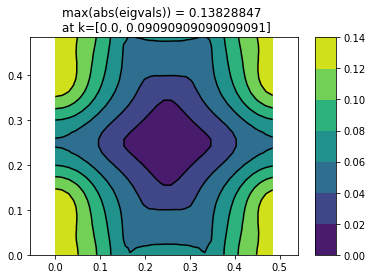

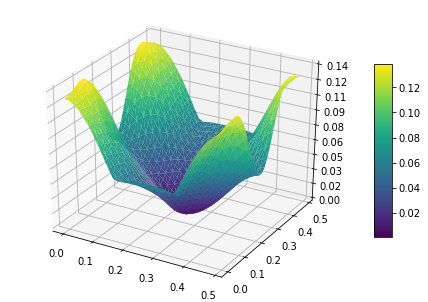

In [10]:
GstrReverse = ''
for i in [3, 2, 1, 0]:
    pinv_si_str = "pinv('S" + str(i) + "')"
    GstrReverse += "@('I' - " + pinv_si_str + "@'L')"
GstrReverse = GstrReverse[1:]

# analysis of the two-grid method.
twogridSymmetrized = alfa.Operator_Composition(X, GstrReverse + Kstr + Gstr)
# resolution of the dual lattice: 33x33
twogridSymmetrized.compute_spectrum(33)

# plot...
plt.figure()
twogridSymmetrized.plot_spectrum()
plt.figure()
twogridSymmetrized.plot_spectrum_3d()

### We reproduce the plot 8.2 of the paper https://epubs.siam.org/doi/abs/10.1137/070679119:

In [11]:
import pandas as pd

# sampling of sigma:
x = np.linspace(1e-6, 1.5, 22)
y = np.linspace(-.7, .7, 22)
xv, yv = np.meshgrid(x, y)

z = np.empty(xv.shape)


for itx in range(x.shape[0]):
    for ity in range(y.shape[0]):
        L = alfa.gallery.operators.curlcurl(
            xv[itx, ity] + 1j*yv[itx, ity])  # curlcurl operator
        Lc = R@L@P  # coarse grid oeprator

        # AFW smoother
        Ls = L.wrt_lattice(slattice)
        Ls.normalize()

        S = {}
        for j in range(len(shifts)):
            Ls_shifted = Ls.change_structure_elements(
                [x + L.C.A@shifts[j] for x in Ls.C.s])
            stmp = alfa.tools.central_multiplier_of(Ls_shifted, idx)
            S = {**S, **{'S' + str(j): stmp}}
        # indices 0,1, .. 5
        X = {**{x: eval(x) for x in ['I', 'L', 'P', 'Lc', 'R']}, **S}

        # analysis of the two-grid method
        twogrid_cnt = alfa.Operator_Composition(X, GstrReverse + Kstr + Gstr)
        # resolution of the dual lattice: 20x20
        twogrid_cnt.compute_spectrum(20)

        # save spectral radius
        z[itx, ity] = np.max(np.abs(twogrid_cnt.df_eigs['eig_0']))

<a list of 6 text.Text objects>

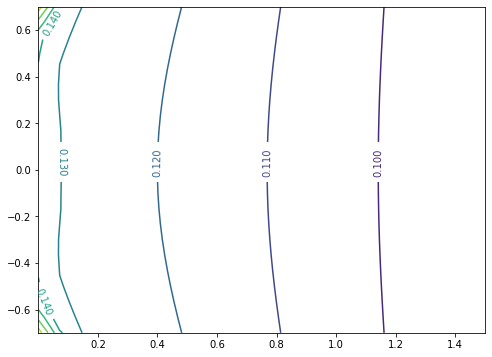

In [12]:
# contour plot w.r.t. sigma
levels = [.09, .1, .11, .12, .13, .14, .15, .16]

levels = 8
plt.figure(figsize=(8, 6))

CS = plt.contour(xv, yv, z, levels)

plt.clabel(CS, inline=1, fontsize=10)